**Deep CNN and SVM Waste Classifier for Recyclability purposes - Chiara Giacanelli**

I firstly import all the important libraries

In [4]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os

I have to link the notebook to my Google Drive so that I can read the dataset contatining the directories with all the images:

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#I firstly load all the files from the path
dir = '/content/drive/MyDrive/WasteClassification'

classes = []
total= 0
for dirname, _, _ in os.walk(dir):
  fn = os.path.basename(dirname)
  if not fn.startswith('.') and dirname != dir: #i remove hidden files
    classes.append(fn)
    total += len(os.listdir(dirname))
    print('total', fn, 'images: ', len(os.listdir(dirname)))

total plastic images:  482
total trash images:  137
total paper images:  594
total glass images:  501
total cardboard images:  403
total metal images:  410


In [12]:
print('There are ', total, ' images in the dataset')

There are  2527  images in the dataset


In [7]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import splitfolders
splitfolders.ratio(dir, output = 'output', seed = 1337, ratio=(.8, 0.1,0.1))

Copying files: 2527 files [00:30, 82.18 files/s] 


I apply image augmentation on the images with the **keras ImageDataGenerator** that generates batches of tensor image data with real-time data augmentation.

In [14]:
#Image augmentation 

IMAGE_SIZE = 256
batch_size = 32

train_path = '/content/output/train'
val_path = '/content/output/val'
test_path = '/content/output/test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip=True,
    validation_split = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.1
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.1
)

train_datagen = train_datagen.flow_from_directory(
    dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = batch_size,
    subset= 'training'
)

val_datagen = val_datagen.flow_from_directory(
    dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = batch_size,
    subset= 'validation'
)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [25]:
labels = {value: key for key, value in train_datagen.class_indices.items()}
labels #these are the labels that my model will predict

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

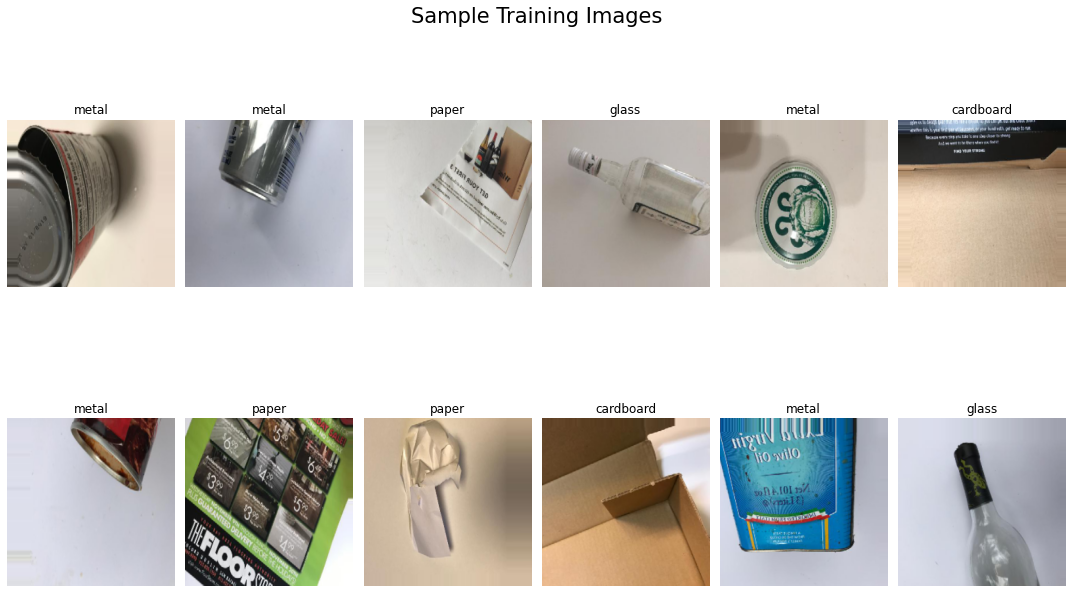

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(6):
        label = labels[np.argmax(train_datagen[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_datagen[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Deep CNN Model 


In [83]:
from tensorflow.keras.models import Sequential
from keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential() 

In [84]:
##adding a convolutional layer and a maxpooling layer

model.add(Conv2D(32, (3,3),  padding='same', activation= 'relu', input_shape= (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3),  padding='same', activation= 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),  padding='same', activation= 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation= 'relu')) #Fully connected layers
model.add(Dropout(0.2)) #added to avoid overfitting --> this will drop 20% of input values for regularizing the dataset and the model as well

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation= 'softmax')) #one of the six outputs

In [85]:
model.compile('adam', loss= tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [86]:
model.build(input_shape = (32,256,256,3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)      

Train


In [ ]:
hist = model.fit(train_datagen, epochs = 50, validation_data = val_datagen, steps_per_epoch= 2276//32, validation_steps= 251//32)

Epoch 1/50
71/71 [==============================] - 41s 551ms/step - loss: 1.7527 - accuracy: 0.2335 - val_loss: 1.6069 - val_accuracy: 0.3571
Epoch 2/50
71/71 [==============================] - 39s 549ms/step - loss: 1.5911 - accuracy: 0.3151 - val_loss: 1.5376 - val_accuracy: 0.3080
Epoch 3/50
71/71 [==============================] - 40s 563ms/step - loss: 1.4712 - accuracy: 0.3766 - val_loss: 1.4281 - val_accuracy: 0.3348
Epoch 4/50
71/71 [==============================] - 39s 547ms/step - loss: 1.4660 - accuracy: 0.3957 - val_loss: 1.4067 - val_accuracy: 0.3929
Epoch 5/50
71/71 [==============================] - 39s 546ms/step - loss: 1.4028 - accuracy: 0.4381 - val_loss: 1.3973 - val_accuracy: 0.4196
Epoch 6/50
71/71 [==============================] - 40s 561ms/step - loss: 1.3890 - accuracy: 0.4176 - val_loss: 1.3227 - val_accuracy: 0.4509
Epoch 7/50
71/71 [==============================] - 40s 561ms/step - loss: 1.3611 - accuracy: 0.4403 - val_loss: 1.3107 - val_accuracy: 0.4866

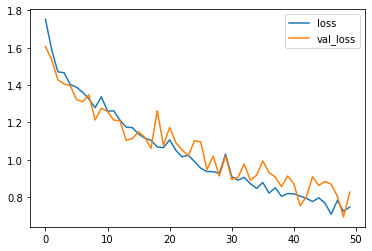

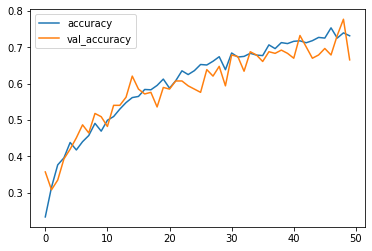

In [ ]:
history_frame = pd.DataFrame(hist.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

Now i can test the model with random images not belonging to the dataset: I created another folder in my drive called *'test_waste_classification'* in which I downloaded many images found online for each of the class labels. I could have also downloaded themselves directly from Google Images but I thought that using the drive could be easier to test the images on. 

(256, 256, 3)


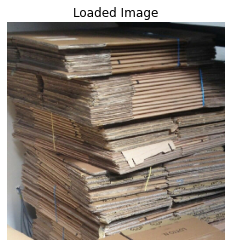

In [ ]:
from keras.preprocessing import image

#I try the model on one unseen instance
img_path ='/content/drive/MyDrive/test_waste_classification/cardboard/card.jfif'

img = image.load_img(img_path, target_size=(256, 256, 3))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())
print(img.shape)

In [ ]:
p = model.predict(img[np.newaxis, ...])

print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Maximum Probability:  0.89358824
Classified: cardboard



-------------------Individual Probability--------------------------------

cardboard : 89.36 %
glass : 0.0 %
metal : 8.85 %
paper : 1.72 %
plastic : 0.07 %
trash : 0.0 %


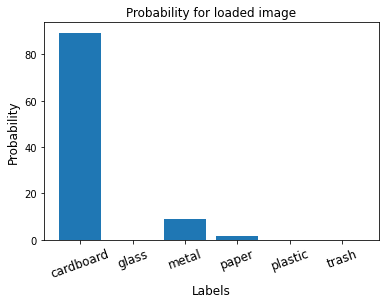

In [ ]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i],':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

The model accurately predicted the class label of the image, with 89% of probability.

We can try to test the model on 20 random images from the test set:

In [92]:
import random
test_path = '/content/output/test'
correct = 0

for i in range(20):
  list_path = os.listdir(test_path)
  class_label = random.choice(list_path)
  fn = test_path + '/' + class_label
  image_path = fn + '/' + random.choice(os.listdir(fn))
  
  print(image_path)

  img = image.load_img(image_path, target_size=(256, 256, 3))
  img = image.img_to_array(img, dtype=np.uint8)
  img=np.array(img)/255.0
  p = model.predict(img[np.newaxis, ...])

  print("Maximum Probability: ",np.max(p[0], axis=-1))
  predicted_class = labels[np.argmax(p[0], axis=-1)]
  if class_label == predicted_class:
    correct += 1
  print("Classified:",predicted_class, "✔️" if class_label == predicted_class else "❌")
  print('------------')
  

/content/output/test/plastic/plastic407.jpg
Maximum Probability:  0.9896842
Classified: plastic ✔️
------------
/content/output/test/metal/metal401.jpg
Maximum Probability:  0.76098365
Classified: metal ✔️
------------
/content/output/test/trash/trash6.jpg
Maximum Probability:  0.69063675
Classified: glass ❌
------------
/content/output/test/cardboard/cardboard73.jpg
Maximum Probability:  0.9843509
Classified: cardboard ✔️
------------
/content/output/test/cardboard/cardboard392.jpg
Maximum Probability:  0.80563736
Classified: cardboard ✔️
------------
/content/output/test/trash/trash137.jpg
Maximum Probability:  0.3955313
Classified: metal ❌
------------
/content/output/test/glass/glass87.jpg
Maximum Probability:  0.36456296
Classified: metal ❌
------------
/content/output/test/metal/metal369.jpg
Maximum Probability:  0.5092127
Classified: metal ✔️
------------
/content/output/test/plastic/plastic384.jpg
Maximum Probability:  0.99276227
Classified: plastic ✔️
------------
/content/out

In [93]:
print(correct, 'out of 20 images were correctly predicted!')

17 out of 20 images were correctly predicted!


SVM

I started by splitting the dataset in training e testing set, because I had to train the model with one-dimensional data. 

In [95]:
from skimage.io import imread
from skimage.transform import resize

target = []
flat_data = []

for c in classes: 
  for img in os.listdir(os.path.join(dir, c)):
    img_resized = resize(imread(os.path.join(os.path.join(dir, c), img)), (150, 150, 3))
    flat_data.append(img_resized.flatten())
    target.append(classes.index(c))

flat_data = np.array(flat_data)
target = np.array(target)

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(flat_data, target, test_size = 0.2, random_state= 42)

In [ ]:
np.unique(y_train, return_counts= True)

(array([0, 1, 2, 3, 4, 5]), array([388, 104, 481, 398, 320, 330]))

There's some inbalance in the classes, so I will apply the SMOTE upsampling technique. 

In [97]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

np.unique(y_resampled, return_counts= True)

(array([0, 1, 2, 3, 4, 5]), array([481, 481, 481, 481, 481, 481]))

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

svc = svm.SVC(C= 1, kernel = 'rbf', gamma= 'scale')
svc.fit(X_train, y_train)

SVC(C=1)

In [ ]:
y2 = svc.predict(X_test)

Accuracy on unknown data is 0.6185770750988142 

              precision    recall  f1-score   support

           0       0.59      0.65      0.62        94
           1       0.77      0.30      0.43        33
           2       0.64      0.81      0.72       113
           3       0.53      0.57      0.55       103
           4       0.74      0.67      0.70        83
           5       0.58      0.44      0.50        80

    accuracy                           0.62       506
   macro avg       0.64      0.58      0.59       506
weighted avg       0.63      0.62      0.61       506



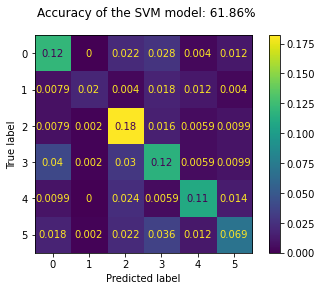

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Accuracy on unknown data is",accuracy_score(y_test,y2), '\n')

print(classification_report(y_test,y2))
disp = ConfusionMatrixDisplay.from_estimator(
        svc,
        X_test,
        y_test,
    normalize = 'all')
plt.suptitle('Accuracy of the SVM model: {:.2%}'.format(accuracy_score(y_test, y2)))
plt.show()

Combination of CNN and SVM (CNN with SVM as output layer instead of softmax layer)

In [55]:
##adding a convolutional layer and a maxpooling layer
model_svm = Sequential()
model_svm.add(Conv2D(32, (3,3),  padding='same', activation= 'relu', input_shape= (256, 256, 3)))
model_svm.add(MaxPooling2D())

model_svm.add(Conv2D(64, (3,3),  padding='same', activation= 'relu'))
model_svm.add(MaxPooling2D())

model_svm.add(Conv2D(32, (3,3),  padding='same', activation= 'relu'))
model_svm.add(MaxPooling2D())

model_svm.add(Flatten())

model_svm.add(Dense(64, activation= 'relu')) #Fully connected layers
model_svm.add(Dropout(0.2)) #added to avoid overfitting --> this will drop 20% of input values for regularizing the dataset and the model as well

model_svm.add(Dense(32,activation='relu'))
model_svm.add(Dropout(0.2))

model_svm.add(Dense(6, kernel_regularizer = tf.keras.regularizers.l2(0.01), activation= 'softmax')) #kernel regularizer to implement L2-SVM
model_svm.compile(optimizer = 'adam', loss = 'squared_hinge', metrics= ['accuracy']) #squared hinge loss for SVM


In [56]:
model_svm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)      

In [57]:
hist = model_svm.fit(train_datagen, epochs = 80, validation_data = val_datagen, steps_per_epoch= 2276//32, validation_steps= 251//32)

Epoch 1/80
71/71 [==============================] - 48s 665ms/step - loss: 1.3111 - accuracy: 0.2674 - val_loss: 1.2652 - val_accuracy: 0.3304
Epoch 2/80
71/71 [==============================] - 45s 631ms/step - loss: 1.2439 - accuracy: 0.3694 - val_loss: 1.2237 - val_accuracy: 0.4286
Epoch 3/80
71/71 [==============================] - 45s 637ms/step - loss: 1.2115 - accuracy: 0.4033 - val_loss: 1.2069 - val_accuracy: 0.4196
Epoch 4/80
71/71 [==============================] - 45s 635ms/step - loss: 1.1946 - accuracy: 0.4202 - val_loss: 1.1901 - val_accuracy: 0.4241
Epoch 5/80
71/71 [==============================] - 45s 637ms/step - loss: 1.1760 - accuracy: 0.4488 - val_loss: 1.1655 - val_accuracy: 0.4554
Epoch 6/80
71/71 [==============================] - 45s 630ms/step - loss: 1.1653 - accuracy: 0.4630 - val_loss: 1.1678 - val_accuracy: 0.4286
Epoch 7/80
71/71 [==============================] - 45s 628ms/step - loss: 1.1640 - accuracy: 0.4501 - val_loss: 1.1752 - val_accuracy: 0.4286

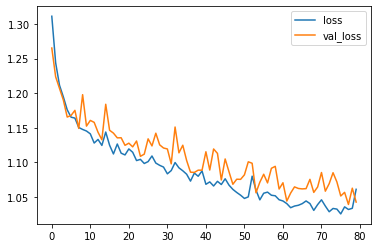

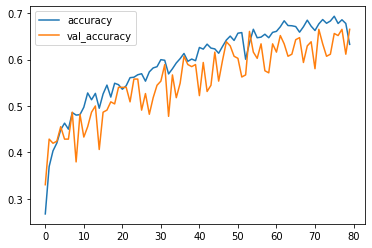

In [58]:
history_frame = pd.DataFrame(hist.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

(256, 256, 3)


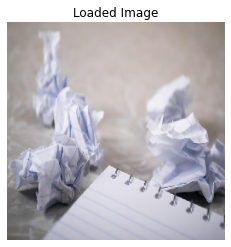

In [59]:
from keras.preprocessing import image

#I try the model on one unseen instance
img_path ='/content/drive/MyDrive/test_waste_classification/paper/paper.jpg'

img = image.load_img(img_path, target_size=(256, 256, 3))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())
print(img.shape)

In [60]:
p = model_svm.predict(img[np.newaxis, ...])

print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Maximum Probability:  0.95905524
Classified: paper


In [77]:
test_path = '/content/output/test'
correct = 0

for i in range(20):
  list_path = os.listdir(test_path)
  class_label = random.choice(list_path)
  fn = test_path + '/' + class_label
  image_path = fn + '/' + random.choice(os.listdir(fn))
  
  print(image_path)

  img = image.load_img(image_path, target_size=(256, 256, 3))
  img = image.img_to_array(img, dtype=np.uint8)
  img=np.array(img)/255.0
  p = model_svm.predict(img[np.newaxis, ...])

  print("Maximum Probability: ",np.max(p[0], axis=-1))
  predicted_class = labels[np.argmax(p[0], axis=-1)]
  if class_label == predicted_class:
    correct += 1
  print("Classified:",predicted_class, "✔️" if class_label == predicted_class else "❌")
  print('------------')
  

/content/output/test/plastic/plastic310.jpg
Maximum Probability:  0.9951573
Classified: plastic ✔️
------------
/content/output/test/metal/metal404.jpg
Maximum Probability:  0.9989786
Classified: metal ✔️
------------
/content/output/test/metal/metal268.jpg
Maximum Probability:  0.79711324
Classified: metal ✔️
------------
/content/output/test/metal/metal67.jpg
Maximum Probability:  0.65079445
Classified: metal ✔️
------------
/content/output/test/trash/trash6.jpg
Maximum Probability:  0.4658789
Classified: glass ❌
------------
/content/output/test/cardboard/cardboard41.jpg
Maximum Probability:  0.5791154
Classified: glass ❌
------------
/content/output/test/trash/trash59.jpg
Maximum Probability:  0.2571686
Classified: glass ❌
------------
/content/output/test/metal/metal285.jpg
Maximum Probability:  0.5860123
Classified: metal ✔️
------------
/content/output/test/trash/trash110.jpg
Maximum Probability:  0.99998224
Classified: paper ❌
------------
/content/output/test/plastic/plastic27

In [78]:
print(correct, 'out of 20 images were correctly predicted by the SVM model!')

12 out of 20 images were correctly predicted by the SVM model!
